# Psychological condition analysis and classification using SVD

Aim: To develop a system that analyzes social media posts to predict psychological conditions such as social anxiety disorder, depression, anxiety, suicidal tendencies, mania, psychosis, substance use disorder, and others using Singular Value Decomposition (SVD)

Dataset: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health

Reference Paper - https://www.engr.uvic.ca/~seng474/svd.pdf


### Workflow Overview:

1. Data Acquisition and Loading:
Load the dataset from Kaggle into a pandas DataFrame for analysis.

2. Data Preprocessing:<br/>
a. Text Cleaning: Remove special characters, numbers, and URLs.<br/>
b. Tokenization: Split text into individual words.<br/>
c. Stop Words Removal: Remove common words that do not contribute to the sentiment.<br/>
d. Stemming/Lemmatization: Reduce words to their base or root form by removing suffixes or other techniques.<br/>
Lemmatization provides a greater accuracy compared to stemming, at the cost of computation.<br/>

3. Creation of TF-IDF Vector:
Convert the cleaned text into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF) vectorization. This allows us to create a sparse matrix, which represents all the posts/textual values in the dataset

4. Dimensionality Reduction using SVD:
Since the sparse matrix created using TFIDF Vectorizer would be too huge, it would be computationally expensive to use the entire matrix for any psychological pattern classification task.
Hence, we apply SVD to the TF-IDF matrix to reduce dimensionality and capture the most significant features.

5. Model Building and Training:
Split the data into training and testing sets.
Train a machine learning classifier (e.g., Logistic Regression, Support Vector Machine) using the reduced features.

6. Model Evaluation:
Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.

---
---

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from nltk.corpus import stopwords
import nltk
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

100%|██████████| 11.1M/11.1M [00:00<00:00, 156MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1

'Combined Data.csv'


In [ ]:
#Reading the dataset and evaluating the same
df = pd.read_csv('/root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv')

In [ ]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
#Dropping unnecessary values
df = df.drop(columns = ['Unnamed: 0'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [ ]:
df.isna().sum()

,0
statement,362
status,0


In [ ]:
#Dropping Null values
df = df.dropna()

In [ ]:
df.isna().sum()

,0
statement,0
status,0


In [ ]:
#Dropping duplicated values
df.duplicated().sum()

1588

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


### Data Preprocessing

In [ ]:
#Removing 1st row since it is erroneous
df = df.iloc[1:,:]

In [ ]:
#Downloading stopwords
nltk.download('stopwords')
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Lemmatization: Used this instead of Stemming since we intend to have greater accuracy
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\\',' ', text) #Remove backslash characters
    text = text.lower()
    tokens = text.split()

    #Removing stop words as well as applying lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the 'text' column
df['proc_stmnt'] = df['statement'].apply(preprocess_text)
df['proc_stmnt']

[nltk_data] Downloading package wordnet to /root/nltk_data...


,proc_stmnt
1,trouble sleeping confused mind restless heart ...
2,wrong back dear forward doubt stay restless re...
3,ive shifted focus something else im still worried
4,im restless restless month boy mean
5,every break must nervous like something wrong ...
...,...
52835,anxiety cause faintness standing title anxiety...
52836,anxiety heart symptom anyone else something si...
52837,travel anxiety hi long time anxiety sufferer f...
52839,fomo thing im involved anyone else get recentl...


In [ ]:
#Creating a copy of the dataset to be used later
df_og = df.copy()

### Conducting Classification

In [ ]:
#Identifying unique status for the posts in the dataset
df.status.value_counts()

,count
status,
Normal,16040
Depression,15094
Suicidal,10644
Anxiety,3622
Bipolar,2501
Stress,2296
Personality disorder,895


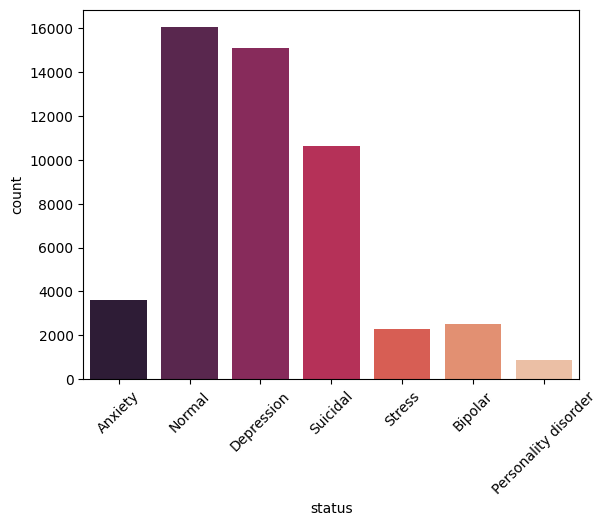

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data = df, x = 'status', hue = 'status',palette = 'rocket')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
df1 = df.loc[df['status'].isin(['Normal', 'Depression','Bipolar','Personality disorder'])]
#df1 = df.copy()

In [ ]:
# Initialize TF-IDF Vectorizer and create a full sparse matrix with all the features (inidicated by max_features having None value)
tfidf_vectorizer = TfidfVectorizer(max_features=None)
x_tfidf = tfidf_vectorizer.fit_transform(df1['proc_stmnt'])

In [ ]:
#Using SVD
#NLP tasks using LSA (Latent Semantic Analysis) or SVD often use 100–500 components for best performance.
#Google’s research on LSA for NLP suggests 300–500 components work well.
svd = TruncatedSVD(n_components=500)

# Fit and transform the TF-IDF features
x_svd = svd.fit_transform(x_tfidf)

In [ ]:
#Splitting into training and testing
# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df1['status'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_svd, y_encoded, test_size=0.25, random_state=42)

In [ ]:
#Identifying the encoding rule used
label_encoder.inverse_transform([0, 1, 2, 3])

array(['Bipolar', 'Depression', 'Normal', 'Personality disorder'],
      dtype=object)

In [ ]:
#Defining the models to be used
from xgboost import XGBClassifier
classification_models = {
    'Logistic Regressor': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state = 42),
    'Random Forest Classifier': RandomForestClassifier(n_estimators = 47, random_state = 47),
    'AdaBoost': AdaBoostClassifier(random_state = 13),
    'Ridge Classifier':RidgeClassifier(),
    'Extra Trees Classifier':ExtraTreesClassifier(n_estimators = 68, random_state = 71),
    'XGBoost Classifier': XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=len(label_encoder.classes_),  # Number of unique classes
    eval_metric='mlogloss',  # Multiclass log loss
    random_state=42)
}

In [ ]:
best_model = None
best_score = 0

print('\nClassification Models: ')
for name, model in classification_models.items():
  pipeline = Pipeline([
      ('classifier',model)
  ])

  #Training the model
  pipeline.fit(X_train, y_train)

  #Prediction
  ypred = pipeline.predict(X_test)

  #Evaluation
  accuracy = accuracy_score(y_test, ypred)
  #f1 = f1_score(y_test, ypred)
  print(f'Accuracy for {name}: {accuracy:.2f}')
  print(f'Classification Report:')
  print(classification_report(y_test, ypred))
  #print('F1 Score: ', f1)

  if best_score < accuracy:
    best_score = accuracy
    best_model = name


Classification Models: 
Accuracy for Logistic Regressor: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       644
           1       0.92      0.92      0.92      3794
           2       0.91      0.96      0.94      3991
           3       0.83      0.45      0.58       204

    accuracy                           0.91      8633
   macro avg       0.88      0.76      0.81      8633
weighted avg       0.91      0.91      0.91      8633

Accuracy for Decision Tree: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54       644
           1       0.85      0.84      0.84      3794
           2       0.87      0.86      0.87      3991
           3       0.22      0.25      0.23       204

    accuracy                           0.82      8633
   macro avg       0.62      0.63      0.62      8633
weighted avg       0.82      0.82      0.82

In [ ]:
print(f"The best classification model is {best_model} with an accuracy of {best_score:.4f}.")

The best classification model is XGBoost Classifier with an accuracy of 0.9137.


---
---
### Final Thoughts
We can make a real time sentiment analysis system to check a users posts to analyze for any underlying psychological conditions. To do the same, we would need to:
1. Freeze the best model that we have found (XGB Classifier)
2. Create a pipeline that preprocesses new posts and converts them into TFIDF vectors followed by SVD.
3. Finally, the model will predict the condition of the user based on the preprocessed input.
4. The output will be filtered so that any person with psychological conditions will be reached out to, for support and any assistance needed.